In [70]:
# Load the relevant packages
import math
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

rcParams['figure.figsize'] = 15, 6

In [2]:
# Load the dataset
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [3]:
# save the number of passengers in ts for ease of access
ts = data['#Passengers']
ts.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

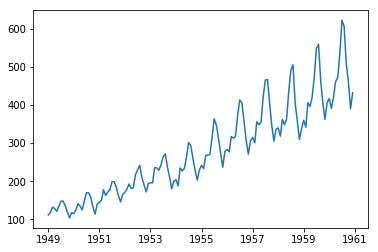

In [4]:
# visualize the data
plt.plot(ts)

In [5]:
# Function to test the stationarity of a time series
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=5).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        print(dfoutput)

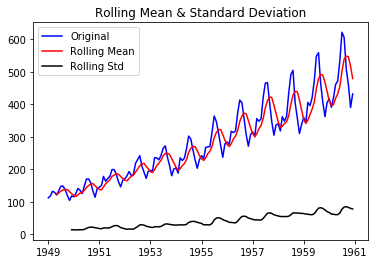

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
dtype: float64
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
dtype: float64
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [6]:
# Test for stationarity
test_stationarity(ts)

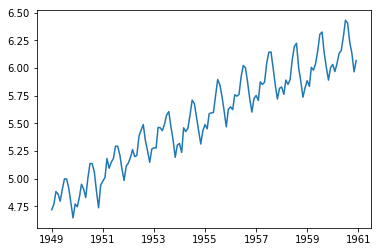

In [7]:
# Lets Estimate or model the trend in the data and then remove it from the series. Take the log of the data
ts_log = np.log(ts)
plt.plot(ts_log)

In this approach, we take average of ‘k’ consecutive values depending on the frequency of time series. Here we can take the average over the past 1 year, i.e. last 12 values. First compute the rolling mean:

In [8]:
ts.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

In [36]:
newData = pd.DataFrame({'Passengers': ts.values, 'RolMean' : ts.rolling(window=12).mean(), 'TSLog': np.log(ts)}, index=ts.index)
newData['DiffRolMean'] = newData.apply(lambda x: x['RolMean']-x['Passengers'] if not math.isnan(x['RolMean']) else 0, axis=1) #
newData = newData.dropna()
newData.head(13)

,Passengers,RolMean,TSLog,DiffRolMean
Month,,,,
1949-12-01,118,126.666667,4.770685,8.666667
1950-01-01,115,126.916667,4.744932,11.916667
1950-02-01,126,127.583333,4.836282,1.583333
1950-03-01,141,128.333333,4.948760,-12.666667
1950-04-01,135,128.833333,4.905275,-6.166667
1950-05-01,125,129.166667,4.828314,4.166667
1950-06-01,149,130.333333,5.003946,-18.666667
1950-07-01,170,132.166667,5.135798,-37.833333
1950-08-01,170,134.000000,5.135798,-36.000000


In [37]:
newData['EWMA'] = newData['Passengers'].ewm(com=0.5).mean()
newData.head()

,Passengers,RolMean,TSLog,DiffRolMean,EWMA
Month,,,,,
1949-12-01,118,126.666667,4.770685,8.666667,118.000000
1950-01-01,115,126.916667,4.744932,11.916667,115.750000
1950-02-01,126,127.583333,4.836282,1.583333,122.846154
1950-03-01,141,128.333333,4.948760,-12.666667,135.100000
1950-04-01,135,128.833333,4.905275,-6.166667,135.033058


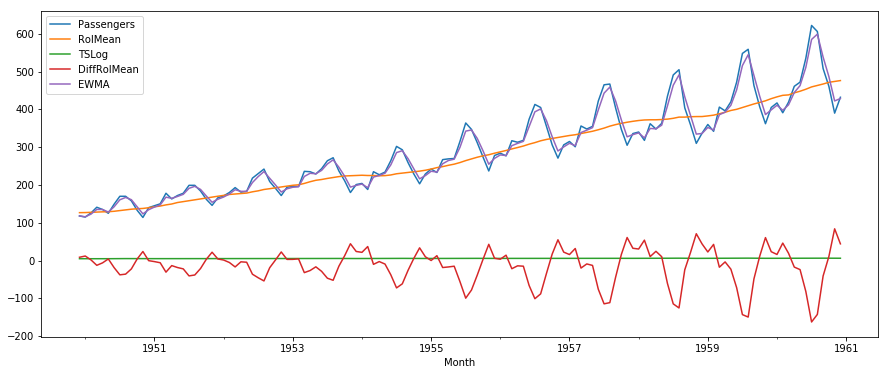

In [38]:
newData.plot()

In [41]:
newTSLog = newData.apply(lambda x: x['Passengers']-x['EWMA'] if not math.isnan(x['Passengers']) and not math.isnan(x['EWMA'])  else 0, axis=1) #
newTSLog.head()

Month
1949-12-01    0.000000
1950-01-01   -0.750000
1950-02-01    3.153846
1950-03-01    5.900000
1950-04-01   -0.033058
Freq: MS, dtype: float64

/Volumes/MacHD01/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/Volumes/MacHD01/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


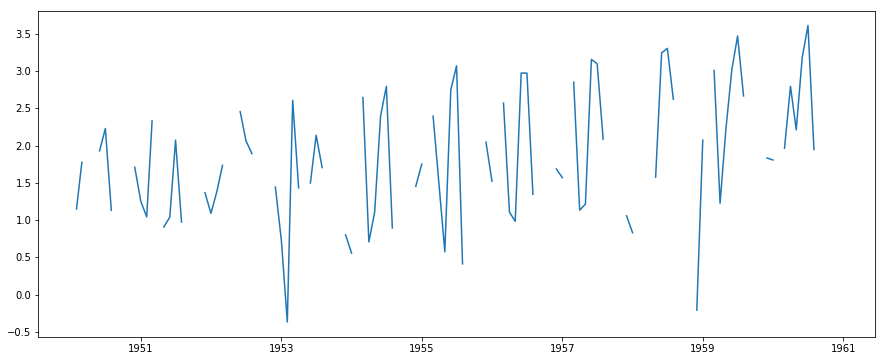

In [42]:
new_ts_log = np.log(newTSLog)
plt.plot(new_ts_log)

One of the most common methods of dealing with both trend and seasonality is differencing. In this technique, we take the difference of the observation at a particular instant with that at the previous instant.

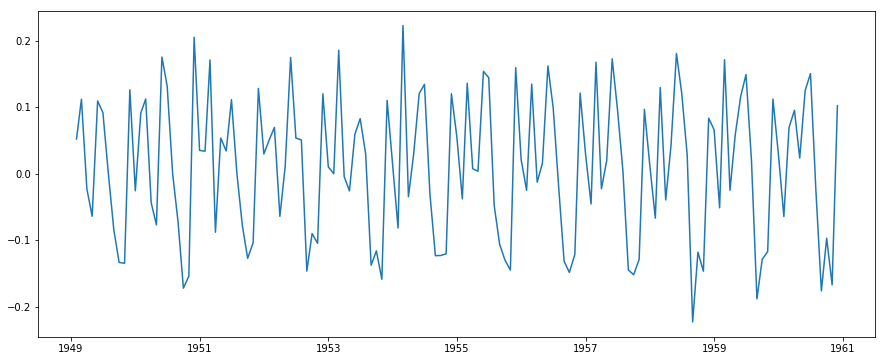

In [43]:
# Use the following formula
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

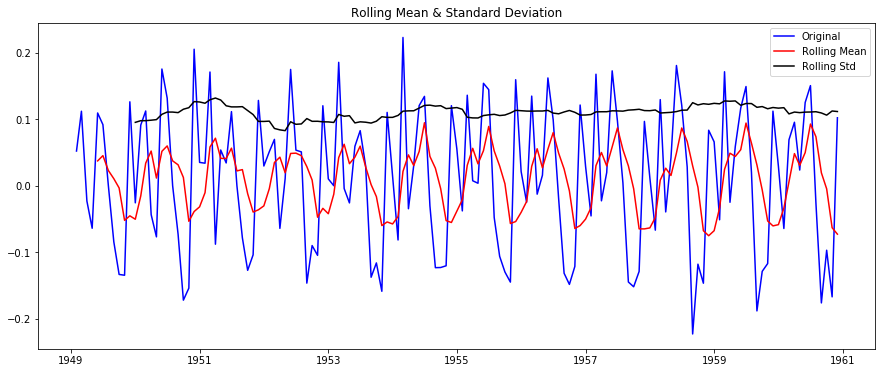

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
dtype: float64
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
dtype: float64
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [45]:
ts_log_diff.dropna(inplace=True)
# Test for stationarity
test_stationarity(ts_log_diff)

ARIMA

In [46]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

                             ARIMA Model Results                              
Dep. Variable:          D.#Passengers   No. Observations:                  143
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -694.988
Method:                       css-mle   S.D. of innovations             31.199
Date:                Tue, 05 Jun 2018   AIC                           1397.975
Time:                        13:40:22   BIC                           1409.827
Sample:                    02-01-1949   HQIC                          1402.791
                         - 12-01-1960                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.4075      3.064      0.786      0.433      -3.597       8.412
ar.L1.D.#Passengers     0.3792      0.082      4.605      0.000       0.218       0.541
ar.L2.D.#Passeng

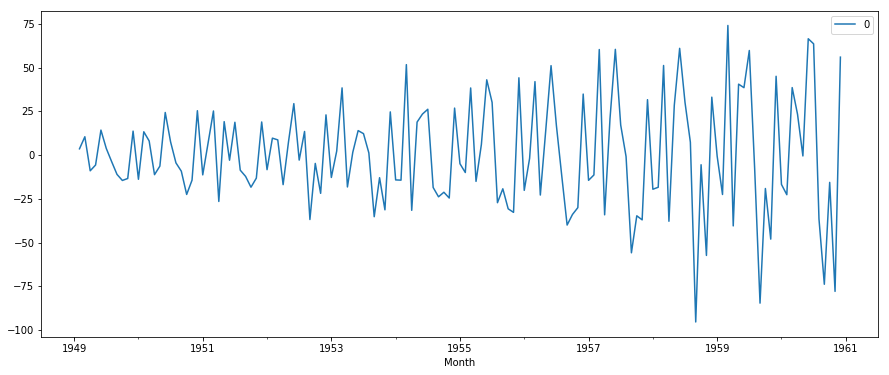

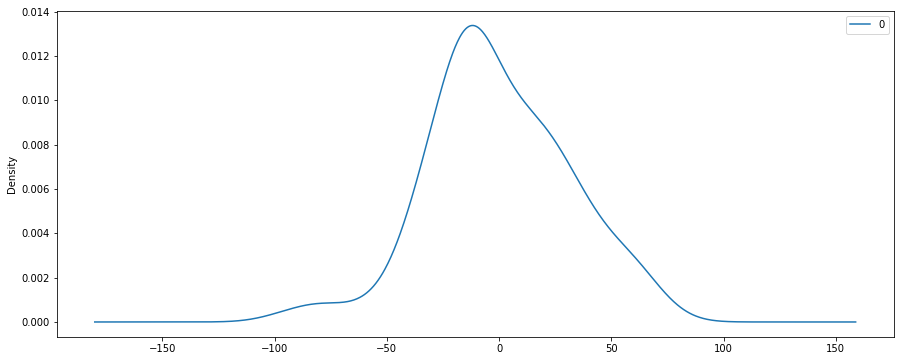

                0
count  143.000000
mean     0.016841
std     31.309377
min    -95.399565
25%    -18.811532
50%     -4.459782
75%     21.848521
max     74.096243


In [56]:
model = ARIMA(ts, order=(2,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

residuals.plot(kind='kde')
plt.show()

print(residuals.describe())

                             ARIMA Model Results                              
Dep. Variable:          D.#Passengers   No. Observations:                  143
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -695.193
Method:                       css-mle   S.D. of innovations             31.214
Date:                Tue, 05 Jun 2018   AIC                           1398.386
Time:                        13:40:43   BIC                           1410.237
Sample:                    02-01-1949   HQIC                          1403.201
                         - 12-01-1960                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.4329      2.850      0.854      0.395      -3.154       8.020
ma.L1.D.#Passengers     0.3736      0.097      3.860      0.000       0.184       0.563
ma.L2.D.#Passeng

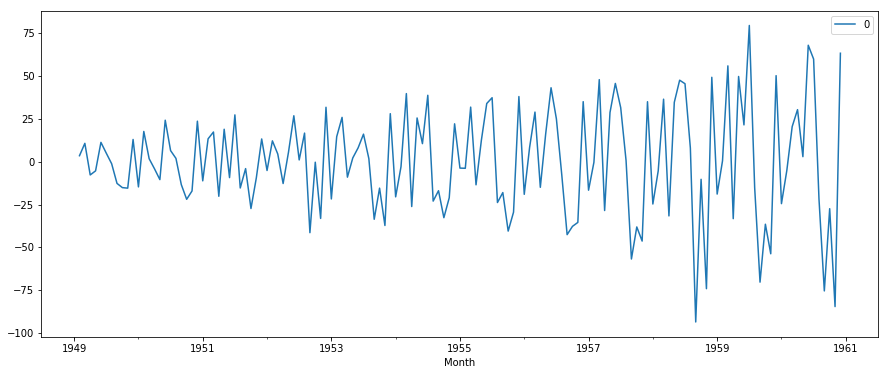

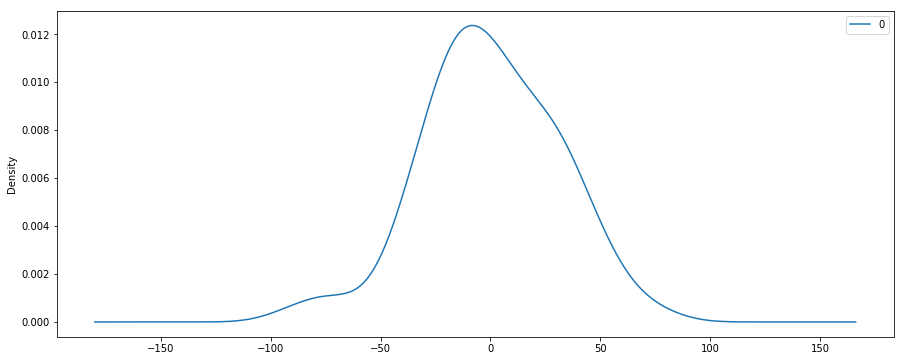

                0
count  143.000000
mean     0.015679
std     31.326445
min    -93.526112
25%    -19.559210
50%     -0.301836
75%     22.958166
max     79.616546


In [57]:
model = ARIMA(ts, order=(0,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

residuals.plot(kind='kde')
plt.show()

print(residuals.describe())

                             ARIMA Model Results                              
Dep. Variable:          D.#Passengers   No. Observations:                  143
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -666.022
Method:                       css-mle   S.D. of innovations             24.715
Date:                Tue, 05 Jun 2018   AIC                           1344.043
Time:                        13:51:13   BIC                           1361.820
Sample:                    02-01-1949   HQIC                          1351.267
                         - 12-01-1960                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.5310      0.708      3.573      0.000       1.143       3.919
ar.L1.D.#Passengers     1.6477      0.033     49.929      0.000       1.583       1.712
ar.L2.D.#Passeng

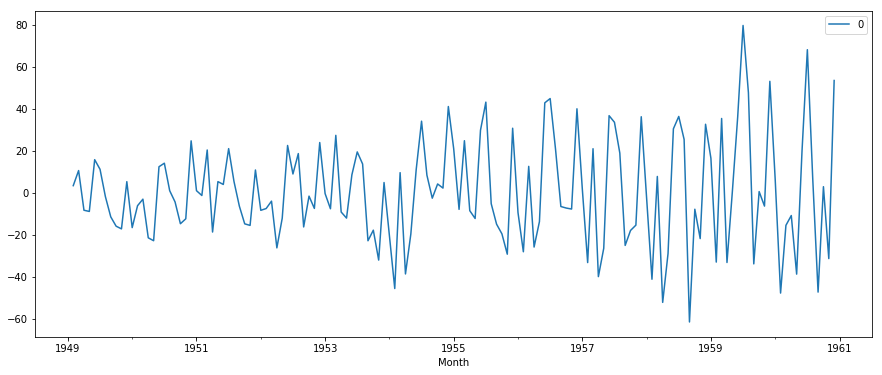

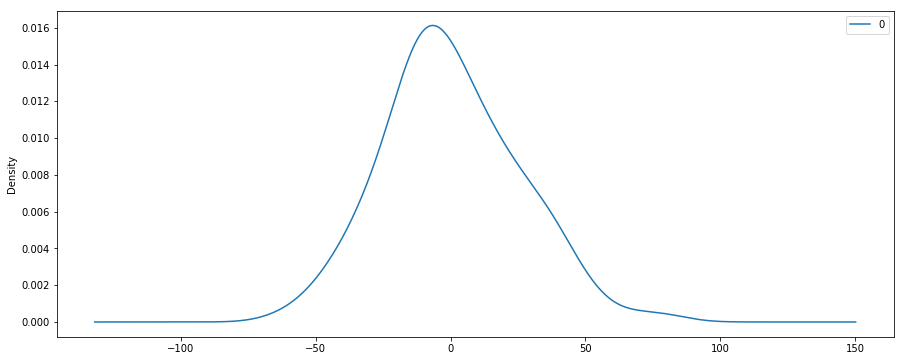

                0
count  143.000000
mean     0.371723
std     25.142955
min    -61.345169
25%    -15.612496
50%     -2.309301
75%     17.612061
max     79.639519


In [64]:
model = ARIMA(ts, order=(2,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

residuals.plot(kind='kde')
plt.show()

print(residuals.describe())

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6917      0.021     82.361      0.000       1.651       1.732
ar.L2         -0.9654      0.018    -54.946      0.000      -1.000      -0.931
ma.L1         -1.8617      0.051    -36.159      0.000      -1.963      -1.761
ma.L2          1.0135      0.054     18.654      0.000       0.907       1.120
sigma2       664.6345     85.215      7.799      0.000     497.616     831.653


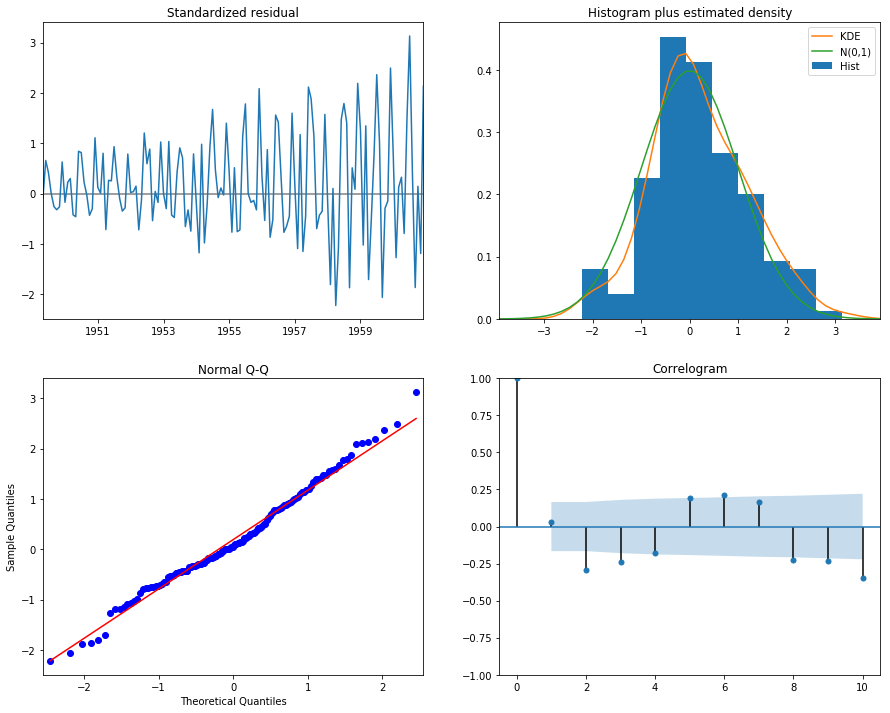

In [72]:
mod = sm.tsa.statespace.SARIMAX(ts,
                                order=(2, 1, 2),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [73]:
pred = results.get_prediction(start=pd.to_datetime('1951-01-01'), dynamic=False)
pred_ci = pred.conf_int()

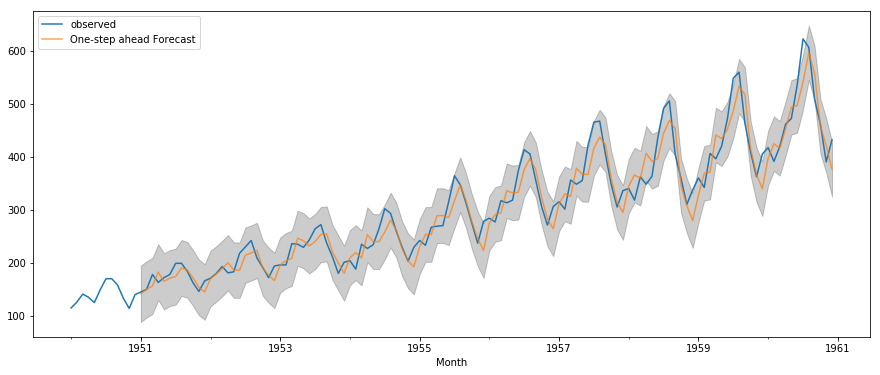

In [76]:
ax = ts['1950':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

plt.legend()
plt.show()

In [77]:
ts_forecasted = pred.predicted_mean
ts_truth = ts['1950-01-01':]

# Compute the mean square error
mse = ((ts_forecasted - ts_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 778.32


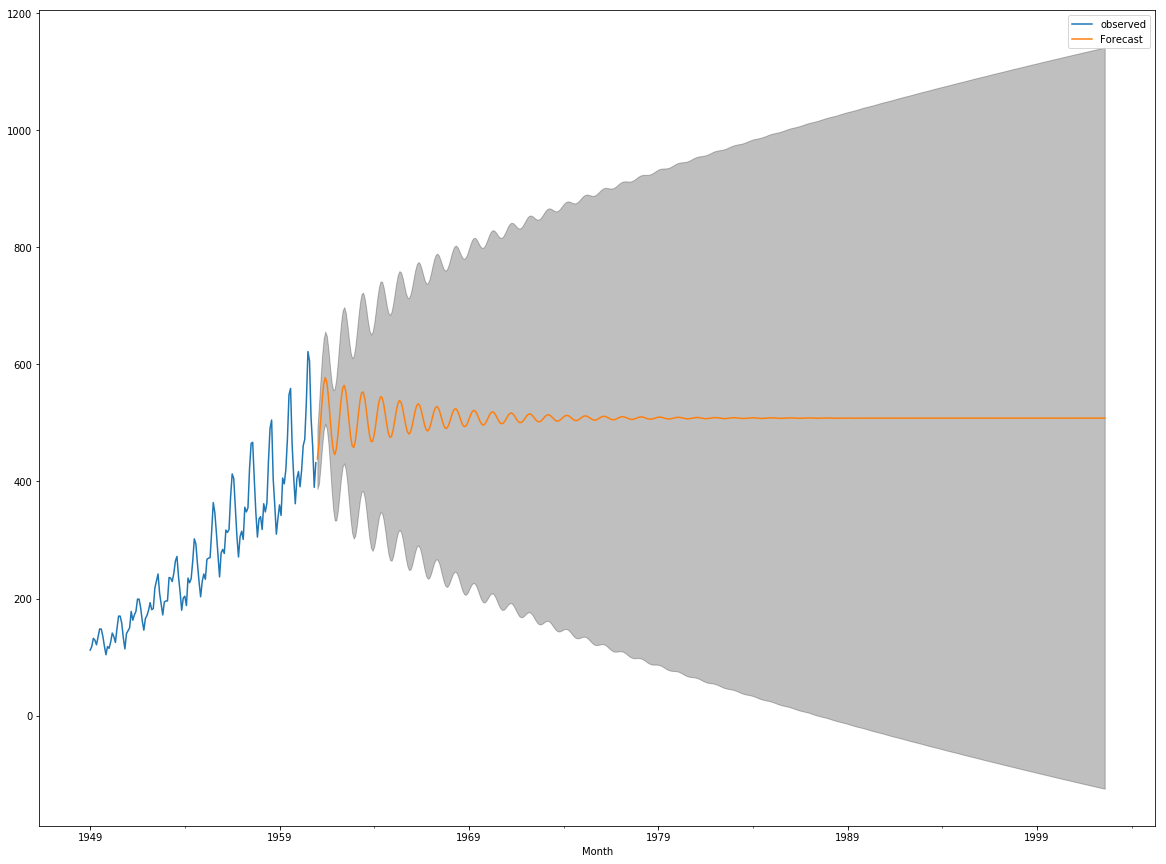

In [78]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = ts.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

plt.legend()
plt.show()